In [2]:
from pandas import Series, read_csv, DataFrame
import random
import matplotlib.pyplot as plt

from generateTestingData.useGeneratedData import makeDataUsable
from geneticAlgorithms.geneticAlgorithm import GeneticAlgorithm
from geneticAlgorithms.useGeneticAlgorithm import printSols
from main.ML.Model import Predicter

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# ga = GeneticAlgorithm(populationLimit=1000,
#                           maxGenerations=1000,
#                         #   maxValue=35,
#                         #   minValue=0,
#                           numberOfVariables=28,
#                           sd=0.2,
#                           mutationChance=0.4,
#                           toKeep=4)
    
# individuals = ga.run()

In [3]:
# p = Predicter()
# p.loadModel("xgb_gen_80-15-37-65")

# solDict = {1:0, 0:0}
# so = []
# for sols in individuals:
#     preProcessed = p.preProcess(list(individuals[0][1]))[0]
#     s = p.predict(preProcessed)
#     solDict[int(s)] += 1
#     so.append(s[0])

# print(solDict)

# printSols(individuals[:10])
# printSols(individuals[-10:])

In [4]:
# comparingData = makeDataUsable(read_csv("../data/generatedData.csv"), 4, 4)

In [5]:
# comparingData.head()

In [6]:
# Dropping time and angular speeds

# comparingData.drop(columns=comparingData.columns[17:-1], axis=1, inplace=True)
# comparingData.drop(columns=comparingData.columns[0], axis=1, inplace=True)

In [7]:
# comparingData = comparingData.loc[comparingData['COL'] == 1]

# print(len(comparingData))
# comparingData.head()

In [8]:
# def findBestMatch(individual, data):
#     bestMatch = (-1, 99999) # index, matchScore, lower is better
#     minVals = data.min()
#     maxVals = data.max()
#     for i, row in data.iterrows():
#         score = 0
#         for val, c, min, max in zip(individual, row, minVals, maxVals):
#             score += abs(c-val)/(max-min)*100
#         if bestMatch[1] > score:
#             bestMatch = (i, score)
#     return bestMatch

# findBestMatch(testingSol, comparingData)


In [9]:
# Extracing relevant features from solutions
def getRelevantDataFromIndividuals(individuals):
    return [ind[1][:16] for ind in individuals]
    # sortedInd = []
    # for _, ind in individuals:
    #     sortedInd.append(ind[:16])
    # return sortedInd

# relIndividuals = getRelevantDataFromIndividuals(individuals)
# print(len(relIndividuals))
# print(relIndividuals[:3])

In [10]:
def findBestMatch(rank, individual, data, minVals, maxVals):
    rowIndex = -1
    bestScore = 99999
    for i, row in data.iterrows():
        score = 0
        for colIndex, (val, c, min, max) in enumerate(zip(individual, row, minVals, maxVals)):
            if colIndex > 7 and colIndex < 12:
                continue
            score += abs(c-val)/(max-min)*100
        if bestScore > score:
            rowIndex = i
            bestScore = score
    return rank, rowIndex, bestScore

In [11]:
def findAllMatches(individuals, data, removeRows=True):
    matches = []
    data = data[data.columns[:-1]].copy()
    minVals = data.min()
    maxVals = data.max()
    amount = len(individuals)
    for rank, individual in enumerate(individuals):
        matches.append(findBestMatch(rank, individual, data, minVals, maxVals))
        if removeRows:
            data.drop(matches[-1][1], inplace=True)
        if (rank+1) % 100 == 0:
            print(f"Found a match for {rank+1} out of {amount} individuals", end="\r")
    print()
    print("Found a match for all individuals.")
    return matches

In [12]:
# Find the score of genetic algorithm
def accuracy(matches, data):
    percent = [5,10,25,50,100]
    for p in percent:
        amount = int(p/100 * len(matches))
        correct = 0
        for _, rowIndex, _ in matches[:amount]:
            correct += data.loc[rowIndex]["COL"]
        print(f"Accuracy for top {p}% individuals from GA:".ljust(42), correct/amount, f"\t{int(correct)} out of {amount}")

# accuracy(allMatches)

# Loading data

In [25]:
comparingData = makeDataUsable(read_csv("../data/generatedData.csv"), 4, 4)
comparingData.drop(columns=comparingData.columns[17:-1], axis=1, inplace=True)
comparingData.drop(columns=comparingData.columns[0], axis=1, inplace=True)
# comparingData = comparingData.loc[comparingData['COL'] == 1]
print(f"Number of rows: {len(comparingData)}")
display(comparingData.head())

Number of rows: 3950


,TTC1,TTC2,TTC3,TTC4,DTO1,DTO2,DTO3,DTO4,JERK1,JERK2,JERK3,JERK4,Speed1,Speed2,Speed3,Speed4,COL
0,50.0,50.0,50.0,50.000,16.6264,100.0,100.0,100.0000,0.004,0.661,4.117,0.865,2.881,0.661,5.439,11.082,0.0
1,50.0,50.0,50.0,50.000,100.0000,100.0,100.0,100.0000,0.661,4.117,0.865,3.704,0.661,5.439,11.082,13.021,0.0
2,50.0,50.0,50.0,50.000,100.0000,100.0,100.0,100.0000,4.117,0.865,3.704,2.233,5.439,11.082,13.021,12.727,0.0
3,50.0,50.0,50.0,50.000,100.0000,100.0,100.0,100.0000,0.865,3.704,2.233,0.009,11.082,13.021,12.727,12.442,0.0
4,50.0,50.0,50.0,5.322,100.0000,100.0,100.0,83.3296,3.704,2.233,0.009,2.308,13.021,12.727,12.442,14.465,0.0


# Generating individuals from the genetic algorithm

In [18]:
ga = GeneticAlgorithm(populationLimit=1000,
                          maxGenerations=1000,
                        #   maxValue=35,
                        #   minValue=0,
                          numberOfVariables=28,
                          selectionRate=3,
                          # sd=0.2,
                          mutationChance=0.6,
                          fitnessGoal = 20000,
                          toKeep=2)
    
individuals = ga.run()

=== Gen 0 best individual ===
	Fitness: 0.05367411      Values: (2.593142130872053, 11.184409123593667, 0.34727068623195123, 38.93869355421921, 38.24766845431642, 30.68616287584672, 21.360567090695113, 89.68142885724103, 66.972819670604, 82.74370028415939, 38.41987558043869, 10.05434173866967, 19.601803223058752, 10.026842018645475, 15.054071830040513, 1.8753934805498815, -0.43472611540605355, 0.7870778459884942, 0.2620838741551901, 0.4888623300793727, 0.44124410420389226, -0.36787217076750434, 1.4185158368508166, 0.632073795540936, -0.7126352258070203, -1.1535242249165798, 0.27213933975269144, -0.1094908814722293)
=== Gen 100 best individual ===
	Fitness: 1.07664705      Values: (2.8644694350842244, 2.941681217897859, 5.219174003423866, 0.9809975342273702, 32.39225468773155, 26.96970065458258, 15.7963963276392, 9.618006284633708, 57.466583029147785, 64.59612187434522, 63.93029370703809, 18.23796321687191, 15.846484651952387, 10.13787073638374, 3.001838384534352, 19.422093443965704, 0.

# Predicting if the individuals can lead to a collision
* 1 = Collision
* 0 = not a collision

In [21]:
p = Predicter()
p.loadModel("xgb_gen_80-15-37-65")
# p.loadModel("xgb_gen_438-6-20-10")

solDict = {1:0, 0:0}
so = []
for individual in individuals[:20]:
    preProcessed, _ = p.preProcess(list(individual[1]))
    s = p.predict(preProcessed)
    solDict[int(s)] += 1
    so.append(s[0])

print(so)
print(solDict)

printSols(individuals[:10])
printSols(individuals[-10:])

Model loaded!
[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
{1: 19, 0: 1}

Score: 5.547      TTCs: [4.691, 0.796, 1.418, 0.777]       DTOs: [26.513, 2.382, 29.128, 5.983]     JERKs: [57.792, 22.257, 84.652, 55.808]  Speeds: [6.038, 7.001, 31.437, 21.834]   
Score: 4.051      TTCs: [4.691, 1.011, 1.418, 0.777]       DTOs: [26.513, 2.382, 29.128, 5.983]     JERKs: [12.421, 22.257, 84.652, 2.867]   Speeds: [6.038, 4.766, 31.437, 21.834]   
Score: 0.769      TTCs: [3.982, 1.551, 1.009, 0.766]       DTOs: [35.011, 7.892, 5.501, 4.856]      JERKs: [23.794, 22.257, 47.824, 54.432]  Speeds: [10.262, 6.297, 10.909, 10.423]  
Score: 0.567      TTCs: [4.691, 3.198, 1.418, 0.777]       DTOs: [26.513, 2.382, 29.128, 5.983]     JERKs: [12.421, 74.522, 84.652, 2.867]   Speeds: [6.038, 1.408, 31.437, 27.105]   
Score: 0.501      TTCs: [2.149, 0.796, 1.404, 0.766]       DTOs: [12.064, 13.143, 12.736, 3.651]    JERKs: [21.621, 26.005, 48.978, 3.347]   Speeds: [8.795, 19.5, 13.851, 17.638]

In [16]:
# for individual in individuals[:10]:
#     preProcessed = p.preProcess(list(individual[1]))[0]
#     s = p.predict(preProcessed)
#     # solDict[int(s)] += 1
#     print(s)

# Finding best matching row for each
The highest ranking individual gets the first pick, the row is then excluded from available rows.

In [26]:
relIndividuals = getRelevantDataFromIndividuals(individuals)
allMatches = findAllMatches(relIndividuals[:20], comparingData, removeRows=True)


Found a match for all individuals.


In [27]:
for rank, row, score in allMatches[:10]:
    score = round(score, 3)
    print(f"Rank: {rank}".ljust(12) + f"Best matching row: {row}".ljust(27) + f"Score: {score}".ljust(18) + f"The row is a collision: {bool(comparingData.loc[[row]]['COL'].values[0])}")
    # rounded = [round(val, 1) for val in individuals[rank][1]]
    # print(rounded[:16])
    # display(comparingData.loc[[row]])
    

Rank: 0     Best matching row: 696     Score: 147.949    The row is a collision: True
Rank: 1     Best matching row: 2405    Score: 164.345    The row is a collision: True
Rank: 2     Best matching row: 2407    Score: 51.906     The row is a collision: True
Rank: 3     Best matching row: 3670    Score: 188.678    The row is a collision: False
Rank: 4     Best matching row: 3245    Score: 57.305     The row is a collision: True
Rank: 5     Best matching row: 1257    Score: 103.399    The row is a collision: False
Rank: 6     Best matching row: 887     Score: 148.137    The row is a collision: False
Rank: 7     Best matching row: 3106    Score: 110.942    The row is a collision: True
Rank: 8     Best matching row: 262     Score: 146.005    The row is a collision: True
Rank: 9     Best matching row: 4152    Score: 45.477     The row is a collision: True


# Calculates the accuracy for the matches

In [28]:
accuracy(allMatches, comparingData)

Accuracy for top 5% individuals from GA:   1.0 	1 out of 1
Accuracy for top 10% individuals from GA:  1.0 	2 out of 2
Accuracy for top 25% individuals from GA:  0.8 	4 out of 5
Accuracy for top 50% individuals from GA:  0.7 	7 out of 10
Accuracy for top 100% individuals from GA: 0.7 	14 out of 20


## Things for testing

In [195]:
comparingData.loc[1042]["COL"]

0.0

In [192]:
allMatches.sort(key=lambda x:x[1], reverse=True)
allMatches[:10]

[(619, 4149, 725.2101471826709),
 (67, 4148, 664.6749958455312),
 (558, 4147, 799.0827094304891),
 (698, 4144, 614.5711236939995),
 (536, 4143, 795.476272165499),
 (982, 4142, 610.5536165999108),
 (819, 4118, 727.1956356011153),
 (500, 4081, 785.7021393237594),
 (388, 4080, 759.3858954382939),
 (978, 4079, 732.0770550994392)]

In [125]:
d = {}
for r, i, s in allMatches:
    d.setdefault(i, 0)
    d[i] += 1
print(d)

{4149: 1, 4148: 1, 4147: 1, 4144: 1, 4143: 1, 4142: 1, 4118: 1, 4081: 1, 4080: 1, 4079: 1, 4074: 1, 4073: 1, 4072: 1, 4071: 1, 4070: 1, 4069: 1, 4068: 1, 4067: 1, 4066: 1, 4054: 1, 4053: 1, 4052: 1, 4051: 1, 4050: 1, 4049: 1, 3985: 1, 3980: 1, 3979: 1, 3977: 1, 3976: 1, 3975: 1, 3974: 1, 3973: 1, 3972: 1, 3971: 1, 3970: 1, 3969: 1, 3968: 1, 3967: 1, 3965: 1, 3964: 1, 3900: 1, 3899: 1, 3866: 1, 3865: 1, 3847: 1, 3846: 1, 3845: 1, 3844: 1, 3824: 1, 3823: 1, 3822: 1, 3821: 1, 3820: 1, 3819: 1, 3818: 1, 3817: 1, 3816: 1, 3815: 1, 3814: 1, 3813: 1, 3812: 1, 3811: 1, 3806: 1, 3805: 1, 3791: 1, 3719: 1, 3718: 1, 3717: 1, 3716: 1, 3715: 1, 3714: 1, 3713: 1, 3712: 1, 3710: 1, 3708: 1, 3707: 1, 3706: 1, 3705: 1, 3704: 1, 3703: 1, 3702: 1, 3701: 1, 3700: 1, 3699: 1, 3698: 1, 3697: 1, 3696: 1, 3695: 1, 3694: 1, 3693: 1, 3692: 1, 3691: 1, 3690: 1, 3689: 1, 3688: 1, 3687: 1, 3686: 1, 3685: 1, 3684: 1, 3683: 1, 3682: 1, 3681: 1, 3674: 1, 3664: 1, 3663: 1, 3662: 1, 3661: 1, 3622: 1, 3621: 1, 3616: 1, 

In [126]:
display(comparingData.loc[d.keys()])


,TTC1,TTC2,TTC3,TTC4,DTO1,DTO2,DTO3,DTO4,JERK1,JERK2,JERK3,JERK4,Speed1,Speed2,Speed3,Speed4,COL
4149,50.0,50.000,50.000,1.909,100.0000,100.0000,29.5486,23.4454,0.396,11.560,7.196,3.820,9.613,12.215,13.018,12.866,0.0
4148,50.0,50.000,50.000,50.000,100.0000,100.0000,100.0000,29.5486,6.380,0.396,11.560,7.196,9.901,9.613,12.215,13.018,0.0
4147,50.0,50.000,50.000,50.000,43.4143,100.0000,100.0000,100.0000,5.892,6.380,0.396,11.560,10.090,9.901,9.613,12.215,0.0
4144,50.0,1.363,50.000,50.000,100.0000,72.8037,31.5114,43.4143,0.456,1.084,9.096,5.892,10.222,12.185,11.874,10.090,0.0
4143,50.0,50.000,1.363,50.000,100.0000,100.0000,72.8037,31.5114,16.440,0.456,1.084,9.096,7.988,10.222,12.185,11.874,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27,50.0,50.000,50.000,50.000,68.6322,100.0000,100.0000,100.0000,2.940,0.658,5.734,3.167,6.198,11.425,10.918,13.578,0.0
4,50.0,50.000,50.000,5.322,100.0000,100.0000,100.0000,83.3296,3.704,2.233,0.009,2.308,13.021,12.727,12.442,14.465,0.0
3,50.0,50.000,50.000,50.000,100.0000,100.0000,100.0000,100.0000,0.865,3.704,2.233,0.009,11.082,13.021,12.727,12.442,0.0
2,50.0,50.000,50.000,50.000,100.0000,100.0000,100.0000,100.0000,4.117,0.865,3.704,2.233,5.439,11.082,13.021,12.727,0.0


<AxesSubplot:>

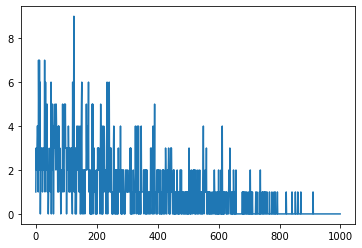

In [100]:
pop = 1000
v = {k: 0 for k in range(pop)}
# print(v)

def selectionTesting():
    def chooseParent():
        return min([random.randint(0, pop) for _ in range(3)])
    parent1 = chooseParent()
    parent2 = chooseParent()
    return (parent1, parent2) if parent1 != parent2 else selectionTesting()

for _ in range(1000//2):
    a, b, = selectionTesting()
    # print(a)
    # print(min(a))
    v[a] += 1
    v[b] += 1
# print(v)
Series(v).plot()

{(32, 28): 5, (81, 1): 4, (36, 1): 4, (28, 5): 4, (78, 36): 4, (28, 8): 4, (6, 2): 4, (10, 9): 4, (32, 6): 4, (65, 35): 4, (77, 73): 4, (28, 11): 4, (131, 63): 3, (144, 56): 3, (33, 10): 3, (146, 32): 3, (80, 41): 3, (66, 20): 3, (164, 13): 3, (199, 4): 3, (114, 22): 3, (190, 2): 3, (141, 20): 3, (111, 56): 3, (57, 8): 3, (57, 50): 3, (100, 70): 3, (36, 23): 3, (54, 17): 3, (89, 8): 3, (236, 53): 3, (56, 29): 3, (161, 53): 3, (60, 49): 3, (101, 21): 3, (50, 11): 3, (52, 33): 3, (36, 25): 3, (98, 10): 3, (57, 38): 3, (79, 19): 3, (106, 14): 3, (152, 68): 3, (64, 43): 3, (51, 2): 3, (61, 9): 3, (81, 3): 3, (245, 90): 3, (171, 31): 3, (127, 106): 3, (108, 60): 3, (134, 133): 3, (17, 15): 3, (38, 25): 3, (27, 6): 3, (209, 61): 3, (61, 34): 3, (34, 0): 3, (210, 24): 3, (102, 29): 3, (87, 1): 3, (259, 46): 3, (13, 3): 3, (124, 70): 3, (118, 74): 3, (32, 0): 3, (34, 21): 3, (158, 113): 3, (141, 38): 3, (84, 4): 3, (80, 16): 3, (90, 55): 3, (39, 22): 3, (74, 34): 3, (62, 50): 3, (76, 4): 3, (9

<AxesSubplot:>

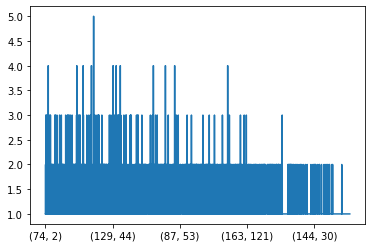

In [42]:
# a = {i:f"{i}{i}{i}" for i in range(5)}
pair = {}
# print(a)

def selectionTesting():
    def chooseParent():
        return min([random.randint(0, 1000) for _ in range(6)])
    parent1 = chooseParent()
    parent2 = chooseParent()
    return (parent1, parent2) if parent1 != parent2 else selectionTesting()

for _ in range(10000):
    par = selectionTesting()
    # print(par)
    par = list(par)
    par.sort(reverse=True)
    par = tuple(par)
    # print(par)
    # print(tuple(par))
    pair.setdefault(par, 0)
    pair[par] += 1

print({k: v for k, v in sorted(pair.items(), key=lambda item: item[1], reverse=True)})
Series(pair).plot()
# p1, p2 = selection(10)
# print(a[p1], a[p2])